In [1]:
%matplotlib inline

import os
import gzip
import multiprocessing
import gensim.models.word2vec as w2v
import sklearn.manifold
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [2]:
#project the results in 2D and 3D
def tsne_plot(components, model):
    col = np.arange(21)
    fig = plt.figure(figsize=(10, 6), dpi=90)
    df = pd.DataFrame() #empty dataframe
    if components == 2:
        #compress the word vectors into 2D space using tsne
        reductio = sklearn.manifold.TSNE(n_components=2, random_state=42)
        vectors_matrix = reductio.fit_transform(model.wv.syn0)
        
        #store the transformed positions in a dataframe
        coords = []
        
        for word in model.wv.vocab:
            x, y = vectors_matrix[model.wv.vocab[word].index]
            coords.append({"aa":word, "x":x, "y":y})
            
        df = pd.DataFrame(coords)
        
        ax = fig.add_subplot(111)
        ax.scatter(df['x'].tolist(), df['y'].tolist(), c=col, s=50)
        for aa, x, y in zip(df['aa'].tolist(), df['x'].tolist(), df['y'].tolist()):
            ax.text(x, y, aa)    
        fig.savefig('plot_tsne_2D.png', dpi=fig.dpi)
        plt.show()
        plt.close('all')  
    elif components == 3:
        from mpl_toolkits.mplot3d import Axes3D
        #Compress the word vectors into 3D space using tsne
        reductio = sklearn.manifold.TSNE(n_components=components, random_state=0)
        vectors_matrix = reductio.fit_transform(model.wv.syn0)
        
        #store the transformed positions in a dataframe
        coords = []
        for word in model.wv.vocab:
            x, y, z = vectors_matrix[model.wv.vocab[word].index]
            coords.append({"aa":word, "x":x, "y":y, "z":z})
            
        df = pd.DataFrame(coords)
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(df['x'].tolist(), df['y'].tolist(), df['z'].tolist(), c=col, s=50)
        for aa, x, y, z in zip(df['aa'].tolist(), df['x'].tolist(), df['y'].tolist(), df['z'].tolist()):
            ax.text(x, y, z, aa)
        fig.savefig('plot_tsne_3D.png', dpi=fig.dpi)
        plt.show()
        plt.close('all')
    return df

In [3]:
#check for analogies i.e., (England - London) + Bogota = X 
#just in case the answer should be Colobmia
def analogy_solver(model, first_pair_1, first_pair_2, second_pair_2):
    '''
    model: w2v model
    first_pair_1: e.g., England (country)
    first_pair_2: e.g., London (capital)
    second_pair_1: e.g., Colombia (country)
    second_pair_2: e.g., Bogota (capital)
    '''
    similarities = model.most_similar_cosmul(
        positive=[second_pair_2, first_pair_1],
        negative=[first_pair_2]
    )
    second_pair_1 = similarities[0][0]
    print("%s is to %s, as %s is to %s" % (first_pair_1, first_pair_2, second_pair_1, second_pair_2))

In [5]:
three_letters = {'A':'ala', 'G':'gly','V':'val', 'L':'leu',
                 'I':'ile', 'P':'pro', 'F':'phe', 'M':'met',
                 'W':'trp', 'C':'cys', 'D':'asp', 'E':'glu',
                 'R':'arg', 'H':'his', 'K':'lys', 'N':'asn',
                 'Q':'gln', 'S':'ser', 'T':'thr', 'Y':'tyr', 
                 'X':'?'} #just in case, not really using it

proteome = []
with gzip.open('arabidopsis_all_proteome.fasta.gz', 'rt') as f:
    for line in f:
        if str(line).strip().startswith('>'):
            continue;
        else:
            if len(str(line).strip()) > 0:
                proteome.append(list(str(line).strip())) #each protein is converted into a list of aminoacids
                
total_aas = sum([len(protein) for protein in proteome])

In [7]:
print("Arabidopsis proteome contains %s aminoacids" % (str(total_aas)))  

Arabidopsis proteome contains 17484985 aminoacids


In [ ]:
#initialize the model
aa2vec = w2v.Word2Vec(
    sg=1,
    seed=42,
    workers=multiprocessing.cpu_count(),
    size=300,
    min_count=1,
    window=7,
)

#build a vocabulary
aa2vec.build_vocab(proteome)

#training the model 
aa2vec.train(proteome, total_examples=aa2vec.corpus_count, epochs=aa2vec.iter)

#save the model
aa2vec.save(os.path.join("models", "aa2vec.w2v"))

In [5]:
#load the trained model
aa2vec = w2v.Word2Vec.load("aa2vec.w2v")

print("aa2vec vocabulary length:", len(aa2vec.wv.vocab))

aa2vec vocabulary length: 21


In [6]:
#check for THE MOST similar aminoacid to isoleucine (I) 
#expecting to get leucine (L)
print("Most similar to I is %s with cosine similarity = %f" % aa2vec.most_similar("I")[0])

Most similar to I is L with cosine similarity = 0.940514


In [7]:
#check for ANALOGY
#glutamate (E) - aspartate(D) + glutamine (Q)  = X 
#expecting to get asparagine (N) 
analogy_solver(aa2vec, "D", "E", "Q") 

D is to E, as N is to Q


In [8]:
#check for ANALOGY
#glutamate (E) - glutamine (Q) + asparagine (N) = X 
#expecting to get glutamate (E) 
analogy_solver(aa2vec, "E", "Q", "N")

E is to Q, as D is to N


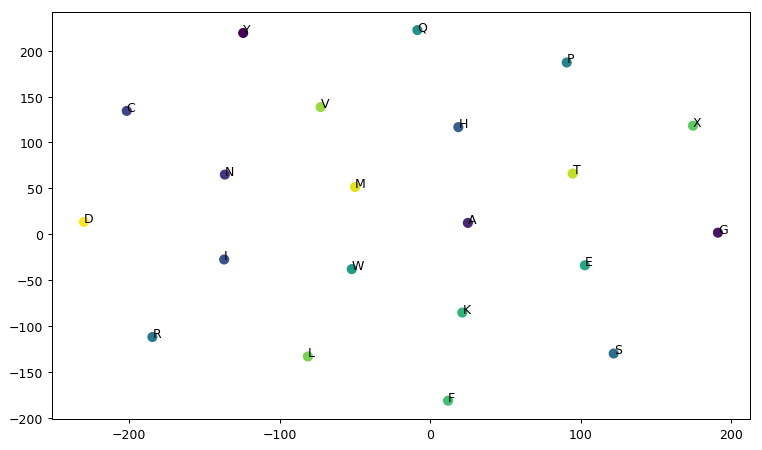

In [9]:
#project model in 2D
df2D = tsne_plot(2, aa2vec)

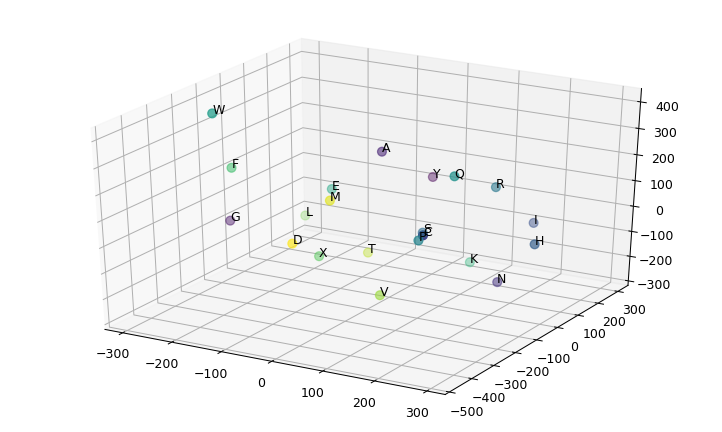

In [10]:
#project model in 3D
df3D = tsne_plot(3, aa2vec)